In [1]:
import scanpy as sc
import cellrank as cr
from cellrank.kernels import RealTimeKernel
from moscot.problems.time import TemporalProblem
import pandas as pd
import numpy as np
import os

# 设置最大线程数

os.environ["OMP_NUM_THREADS"] = "40"
os.environ["OPENBLAS_NUM_THREADS"] = "40"
os.environ["MKL_NUM_THREADS"] = "40"
os.environ["VECLIB_MAXIMUM_THREADS"] = "40"
os.environ["NUMEXPR_NUM_THREADS"] = "40"


In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/AEGAS_data/fate/CellTag2018.h5ad')
#adata = adata[adata.obs['celltype']!='Others']
adata.obs['day'] = 2
adata.obs.loc[adata.obs['celltype'].isin(['Others']), 'day'] = 1

In [3]:
tp = TemporalProblem(adata)
tp = tp.prepare(time_key="day")
tp = tp.solve()
tmk = RealTimeKernel.from_moscot(tp)
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")
g = cr.estimators.GPCCA(tmk)
g.fit(cluster_key="celltype", n_states=2)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2520, 511)].                                   


WARNING  Solver did not converge                                                                                   


100%|██████████| 1/1 [00:00<00:00, 2763.05time pair/s]


GPCCA[kernel=RealTimeKernel[n=3031], initial_states=None, terminal_states=None]

/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


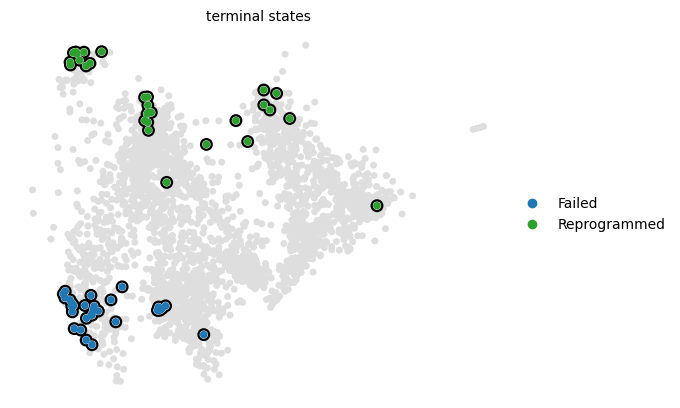

Defaulting to `'gmres'` solver.


100%|██████████| 2/2 [00:00<00:00, 21.65/s]


In [5]:
g.set_terminal_states(states=['Failed', 'Reprogrammed'])
g.plot_macrostates(which="terminal", legend_loc="right", size=100)
g.compute_fate_probabilities()

In [6]:
df1=pd.DataFrame(g.adata.obsm['lineages_fwd'],columns=['Failed','Reprogrammed'])

In [8]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
max_columns = df1.idxmax(axis=1)
adata.obs['pred'] = max_columns.tolist()
adata_final = adata[adata.obs.celltype=='Others']
y_pred = adata_final.obs['pred']
y_true = adata_final.obs['lineage']

# 计算准确性

accuracy = accuracy_score(y_true, y_pred)

# 计算召回率

recall = recall_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 计算F1分数

f1 = f1_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 输出结果

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.3273809523809524
Recall: 0.14565677966101695
F1 Score: 0.1986994219653179


/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/data/jiangjunyao/miniconda3/envs/cellrank/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


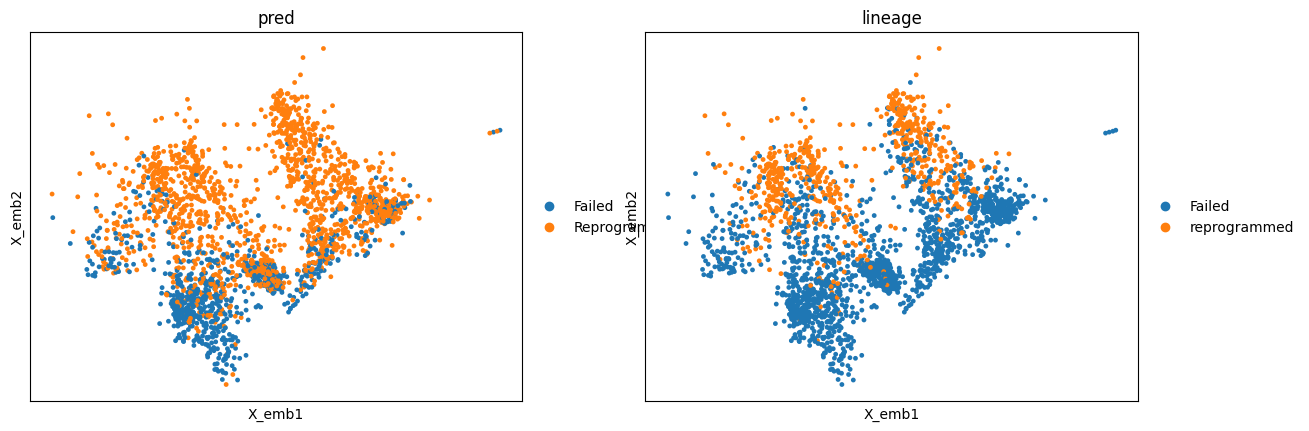

In [10]:
sc.pl.embedding(adata_final,color=['pred','lineage'],basis='X_emb')

In [11]:
adata.write('/data/jiangjunyao/AEGAS_analysis/pred_result/cellrank_celltagy.h5ad')
adata.obs.to_csv('/data/jiangjunyao/AEGAS_analysis/pred_result/cellrank_celltag_obs.csv')